# Projects in Advanced ML Assignment 2
## Covid X-ray Image Classification
### Sofia Zaidman
### 03/13/23

### Importing data and packages

In [ ]:
#load libraries
import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3

In [ ]:
%%capture
# Connect to google drive and unzip data
import os
from google.colab import drive
drive.mount('/content/drive')

!unzip /content/drive/MyDrive/covid_radiography_data/COVID-19_Radiography_Dataset.zip

### Make list of file names

In [ ]:
# Extracting all filenames iteratively
base_path = 'COVID-19_Radiography_Dataset'
categories = ['COVID/images', 'Normal/images', 'Viral Pneumonia/images']

# load file names to fnames list object
fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

print('number of images for each category:', [len(f) for f in fnames])

number of images for each category: [3616, 10192, 1345]


### Keep equal number of files from each category

In [ ]:
#Reduce number of images to first 1345 for each category
fnames[0]=fnames[0][0:1344]
fnames[1]=fnames[1][0:1344]
fnames[2]=fnames[2][0:1344]

### Define image preprocessor

In [ ]:
# Import image, load to array of shape height, width, channels, then min/max transform.
# Write preprocessor that will match up with model's expected input shape.

from keras.preprocessing import image
import numpy as np
from PIL import Image

def preprocessor(img_path):
        img = Image.open(img_path).convert("RGB").resize((192,192)) # import image, make sure it's RGB and resize to height and width you want.
        img = (np.float32(img)-1.)/(255-1.) # min max transformation
        img=img.reshape((192,192,3)) # Create final shape as array with correct dimensions for Keras
        return img

preprocessor('COVID-19_Radiography_Dataset/COVID/images/COVID-2273.png').shape

(192, 192, 3)

### Preprocess all images

In [ ]:
#Import image files iteratively and preprocess them into array of correctly structured data

# Create list of file paths
image_filepaths=fnames[0]+fnames[1]+fnames[2]

# Iteratively import and preprocess data using map function

# map functions apply your preprocessor function one step at a time to each filepath
preprocessed_image_data=list(map(preprocessor,image_filepaths ))

# Object needs to be an array rather than a list for Keras (map returns to list object)
X= np.array(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model

### Check that preprocessing worked

In [ ]:
print(len(X) ) #same number of elements as filenames
print(X.shape ) #dimensions now 192,192,3 for all images
print(X.min().round() ) #min value of every image is zero
print(X.max() ) #max value of every image is one

4032
(4032, 192, 192, 3)
-0.0
1.0


### Make dataframe with correct y labels

In [ ]:
# Create y data made up of correctly ordered labels from file folders
from itertools import repeat

print('number of images for each category:', [len(f) for f in fnames])
covid=list(repeat("COVID", 1344))
normal=list(repeat("NORMAL", 1344))
pneumonia=list(repeat("PNEUMONIA", 1344))

#combine into single list of y labels
y_labels = covid+normal+pneumonia

#check length, same as X above
print(len(y_labels))

# Need to one hot encode for Keras.  Let's use Pandas

import pandas as pd
y=pd.get_dummies(y_labels)

y.head()

number of images for each category: [1344, 1344, 1344]
4032


,COVID,NORMAL,PNEUMONIA
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


## Visualize images that demonstrate when x-rays demonstrate Covid Positivity and when they do not (You can present visuals of each category in the data if you would like to.).

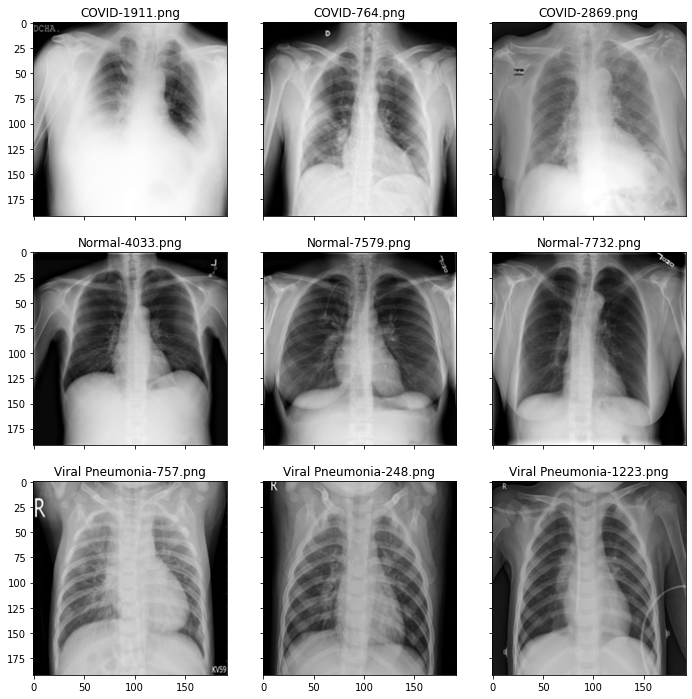

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random

im1 =preprocessor(fnames[0][0])
im2 =preprocessor(fnames[0][1])
im3 =preprocessor(fnames[0][2])
im4 =preprocessor(fnames[1][0])
im5 =preprocessor(fnames[1][1])
im6 =preprocessor(fnames[1][2])
im7 =preprocessor(fnames[2][0])
im8 =preprocessor(fnames[2][1])
im9 =preprocessor(fnames[2][2])

fig = plt.figure(figsize=(12., 12.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 3),  # creates 2x2 grid of axes
                 axes_pad=0.5,  # pad between axes in inch.
                 )

titles = [os.path.basename(fnames[0][0]),
          os.path.basename(fnames[0][1]),
          os.path.basename(fnames[0][2]),
          os.path.basename(fnames[1][0]),
          os.path.basename(fnames[1][1]),
          os.path.basename(fnames[1][2]),
          os.path.basename(fnames[2][0]),
          os.path.basename(fnames[2][1]),
          os.path.basename(fnames[2][2])]
count = 0
for ax, im in zip(grid, [im1, im2, im3, im4, im5, im6, im7, im8, im9]):
    # Iterating over the grid returns the Axes.
    subnum = titles[count]
    ax.imshow(im)
    ax.set_title('{0}'.format(subnum))
    count +=1

## Discuss the dataset in general terms and describe why building a predictive model using this data might be practically useful.  Who could benefit from a model like this? Explain.

The dataset contains a moderate amount of labeled X-ray image data divided into 4 groups (COVID cases, Normal lungs, Viral Pneumonia cases and something called Lung_Opacity which we will not use).

Doctors, patients, hospitals and epidemiologists/other scientists and researchers could all benefit from models to assist in the diagnosis of COVID-related lung disease. 

There is a clear use for this technology in assisting radiologists and physicians in diagnosing COVID-related lung disease vs. pneumonia, especially if, for instance, there is no detectable COVID virus in the patient (perhaps in the case of long-covid). Knowing the cause of specific lung problems could impact the way physicians treat the illness and could make a difference in a patient's recovery and outcome. 

This technology could also impact hospital operations and insurance claims. If a patient is diagnosed with having COVID-related lung issues as opposed to pneumonia, this could result in changes to billing procedures.

Epidemiologists could use diagnostic models to improve data quality for analyses of COVID transmission and incidence of acute COVID illness.

## Run at least three prediction models to try to predict x-ray images well.

### train test split

In [ ]:
# ======Train test split resized images (Hackathon Note!! Use same train test split to be able to submit predictions to leaderboard!)=======================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.32, random_state = 1987)

X_test.shape, y_test.shape

((1291, 192, 192, 3), (1291, 3))

In [ ]:
#Clear objects from memory
del(X)
del(y)
del(preprocessed_image_data)

### Save data to pickle objects in case runtime is restarted

In [ ]:
#Save data to be able to reload quickly if memory crashes or if you run Runtime>Restart Runtime
import pickle

# Open a file and use dump()
with open('X_train.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(X_train, file)

# Open a file and use dump()
with open('X_test.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(X_test, file)

# Open a file and use dump()
with open('y_train.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(y_train, file)

# Open a file and use dump()
with open('y_test.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(y_test, file)

In [ ]:
#If you run out of Colab memory restart runtime, reload data and try again

# Open the file in binary mode
with open('X_train.pkl', 'rb') as file:
    # Call load method to deserialze
    X_train = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)

### Install AI modelshare

In [ ]:
%%capture
# Begin to submit models to image classification leaderboard
! pip install aimodelshare --upgrade
# Restart session Runtime > Restart runtime

### First model

In [ ]:
import tensorflow as tf

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    # classifying into 3 categories
    tf.keras.layers.Dense(3, activation='softmax')
  ])
  #from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  #red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

  model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model.fit(X_train, y_train, 
                    epochs = 14, verbose=1,validation_split=.2) #, callbacks=[red_lr]) for callback that automatically adjusts lr

So this was my first model, but not the first model I submitted (due to the experiment submission not working). I used the basic sequential framework and decided to have all filters be 32 for each Conv2D layer. I chose 14 epochs to train the model somewhat randomly but 14 seems to be a good number where the validation accuracy seems to peek, I've found just with trial and error. Also, after running out of GPU, 14 epochs takes about 30 minutes which is a manageable amount of time to wait. 

I believe I ended up submitting this model as model #11 on the leaderboard. It didn't end up as my best performing model but it certainly wasn't bad. I used this model as a jumping off point for experimenting in subsequent models. 

### Save model to environment and submit to modelshare

In [ ]:
model.save("model1.h5", save_format="h5")

In [ ]:
# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [ ]:
#Use X_test data to generate model predictions and make leaderboard submission

#Generate and save predictions
    
prediction_column_index=model.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

41/41 [==============================] - 52s 1s/step


In [ ]:
apiurl='https://bb4mkgq8sb.execute-api.us-east-2.amazonaws.com/prod/m'

import aimodelshare as ai
experiment= ai.Experiment(apiurl)

from aimodelshare.aws import set_credentials
set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


In [ ]:
experiment.inspect_y_test()

{'ytest_example': ['PNEUMONIA', 'COVID', 'NORMAL', 'NORMAL', 'COVID'],
 'y_length': 1291,
 'class_labels': ['PNEUMONIA', 'NORMAL', 'COVID'],
 'class_balance': {'PNEUMONIA': 431, 'COVID': 430, 'NORMAL': 430},
 'label_dtypes': {"<class 'str'>": 1291}}

In [ ]:
# Submit Model 1 to Competition Leaderboard
experiment.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath=None,
                                 prediction_submission=prediction_labels)

Insert search tags to help users find your model (optional): image augmentation
Provide any useful notes about your model (optional): image augmentation

Your model has been submitted as model version 212

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


### Second model

In [ ]:
import tensorflow as tf

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=16, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=16, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=16, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    # classifying into 3 categories
    tf.keras.layers.Dense(3, activation='softmax')
  ])
  #from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  #red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

  model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model.fit(X_train, y_train, 
                    epochs = 16, verbose=1,validation_split=.2) #, callbacks=[red_lr]) for callback that automatically adjusts lr

Epoch 1/16
69/69 [==============================] - 130s 2s/step - loss: 0.8974 - accuracy: 0.5338 - val_loss: 0.5942 - val_accuracy: 0.7268
Epoch 2/16
69/69 [==============================] - 131s 2s/step - loss: 0.5875 - accuracy: 0.7509 - val_loss: 0.5230 - val_accuracy: 0.7905
Epoch 3/16
69/69 [==============================] - 125s 2s/step - loss: 0.4630 - accuracy: 0.8079 - val_loss: 0.4161 - val_accuracy: 0.8160
Epoch 4/16
69/69 [==============================] - 145s 2s/step - loss: 0.3796 - accuracy: 0.8504 - val_loss: 0.3520 - val_accuracy: 0.8652
Epoch 5/16
69/69 [==============================] - 226s 3s/step - loss: 0.3186 - accuracy: 0.8745 - val_loss: 0.3119 - val_accuracy: 0.8944
Epoch 6/16
69/69 [==============================] - 149s 2s/step - loss: 0.2733 - accuracy: 0.8955 - val_loss: 0.3340 - val_accuracy: 0.8725
Epoch 7/16
69/69 [==============================] - 128s 2s/step - loss: 0.2373 - accuracy: 0.9115 - val_loss: 0.3063 - val_accuracy: 0.8907
Epoch 8/16
69

In [ ]:
model.save("model2.h5", save_format="h5")

I submitted this model as number 21. After the relative success of reducing the number of filters all to 32 in my first model, I thought maybe I should try reducing the filters even more in my second model. I kept the first couple Conv2D layers at 32 and went down to 16 for the remaining Conv2D layers. I also upped the epochs from 14 to 16 to see if a couple more epochs could help.

Sadly the performance of the model in predicting validation data seemed to peak and the plateau at around epoch 10. This model actually did slightly worse than my first model on the leaderboard.

### A transfer learning try

In [ ]:
# example of loading the Inception model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K


# load model new input layer shape.

IMG_SHAPE = (192, 192, 3)

# Create the base model from the pre-trained model VGG16
base_model = InceptionV3(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

#base_model.summary() # Notice unfrozen number of trainable parameters

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
# Next step: Freeze the weights of the model so that they are not trained with you fit the model
# setting the entire model's trainable flag to False will freeze all the layers.

base_model.trainable = False

#base_model.summary() # Note the trainable parameters at the bottom now equal zero.

In [ ]:
# Add new GAP layer and output layer to frozen layers of original model with adjusted input
gap1 = GlobalAveragePooling2D()(base_model.layers[-1].output)
output = Dense(3, activation='softmax')(gap1)
# define new model
model = Model(inputs=base_model.inputs, outputs=output)
# summarize
#model.summary()

In [ ]:
# Fit Inception model with frozen imagenet weights and new input/output layer shapes (outputs have trainable parameters)

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 

  model.fit(X_train, y_train,
          epochs = 14, verbose=1,validation_split=.2)

Epoch 1/14
69/69 [==============================] - 174s 2s/step - loss: 0.6598 - acc: 0.7099 - val_loss: 0.4981 - val_acc: 0.7760
Epoch 2/14
69/69 [==============================] - 182s 3s/step - loss: 0.4045 - acc: 0.8330 - val_loss: 0.4178 - val_acc: 0.8215
Epoch 3/14
69/69 [==============================] - 170s 2s/step - loss: 0.3446 - acc: 0.8558 - val_loss: 0.3458 - val_acc: 0.8561
Epoch 4/14
69/69 [==============================] - 171s 2s/step - loss: 0.2994 - acc: 0.8759 - val_loss: 0.3259 - val_acc: 0.8597
Epoch 5/14
69/69 [==============================] - 165s 2s/step - loss: 0.2872 - acc: 0.8809 - val_loss: 0.3295 - val_acc: 0.8561
Epoch 6/14
69/69 [==============================] - 172s 3s/step - loss: 0.2462 - acc: 0.9015 - val_loss: 0.2997 - val_acc: 0.8816
Epoch 7/14
69/69 [==============================] - 172s 2s/step - loss: 0.2452 - acc: 0.9024 - val_loss: 0.2906 - val_acc: 0.8962
Epoch 8/14
69/69 [==============================] - 181s 3s/step - loss: 0.2372 - a

In [ ]:
model.save("inceptionv3_model.h5", save_format="h5")

So this was actually the first model I submitted to the leaderboard as model #12, even though it wasn't the first model I tried (due to the leaderboard not being open for a week). Sadly it didn't perform very well and I think this could potentially be due to not having enough epochs to train over? It's hard to say. The model is so huge and clunky and my other smaller models did better so I don't think I am going to go deeper into this transfer learning model, but at least I tried. I really didn't change the model except for making the output the correct shape. Maybe if I did something more to it I could improve it but again, I don't think it's worth the time especially because the GPU ran out.

### Batch normalization model

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    BatchNormalization(),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    BatchNormalization(),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    BatchNormalization(),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    BatchNormalization(),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    BatchNormalization(),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    BatchNormalization(),
    tf.keras.layers.Flatten(),
    # classifying into 3 categories
    tf.keras.layers.Dense(3, activation='softmax')
  ])
  #from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  #red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

  model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model.fit(X_train, y_train, 
                    epochs = 14, verbose=1,validation_split=.2) #, callbacks=[red_lr]) for callback that automatically adjusts lr

Epoch 1/14
69/69 [==============================] - 286s 4s/step - loss: 0.6442 - accuracy: 0.7413 - val_loss: 1.2896 - val_accuracy: 0.3206
Epoch 2/14
69/69 [==============================] - 269s 4s/step - loss: 0.3306 - accuracy: 0.8695 - val_loss: 1.6803 - val_accuracy: 0.3206
Epoch 3/14
69/69 [==============================] - 272s 4s/step - loss: 0.2551 - accuracy: 0.8978 - val_loss: 2.0073 - val_accuracy: 0.3206
Epoch 4/14
69/69 [==============================] - 265s 4s/step - loss: 0.1696 - accuracy: 0.9366 - val_loss: 2.6393 - val_accuracy: 0.3206
Epoch 5/14
69/69 [==============================] - 273s 4s/step - loss: 0.1117 - accuracy: 0.9676 - val_loss: 1.8851 - val_accuracy: 0.4936
Epoch 6/14
69/69 [==============================] - 267s 4s/step - loss: 0.0938 - accuracy: 0.9690 - val_loss: 1.3921 - val_accuracy: 0.5246
Epoch 7/14
69/69 [==============================] - 277s 4s/step - loss: 0.0596 - accuracy: 0.9813 - val_loss: 1.3884 - val_accuracy: 0.6430
Epoch 8/14
69

In [ ]:
model.save("model1.h5", save_format="h5")

In [ ]:
# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

onnx_model = model_to_onnx(model, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [ ]:
#Use X_test data to generate model predictions and make leaderboard submission

prediction_column_index=model.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

41/41 [==============================] - 41s 973ms/step


In [ ]:
apiurl='https://bb4mkgq8sb.execute-api.us-east-2.amazonaws.com/prod/m'

import aimodelshare as ai
experiment= ai.Experiment(apiurl)

from aimodelshare.aws import set_credentials
set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


In [ ]:
# Submit Model to Competition Leaderboard
experiment.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath=None,
                                 prediction_submission=prediction_labels)

Insert search tags to help users find your model (optional): another batch normalization
Provide any useful notes about your model (optional): another batch normalization

Your model has been submitted as model version 100

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3340


I think it's super interesting how the model with batch normalization gets so accurate to the training data so fast, but it takes a while for the accuracy of the validation data to catch up. I'm amazed that the model can get 100% accuracy on the training data only after a few epochs.

I submitted a couple very slightly altered versions of this basic model as models 82 and 100 on the leaderboard. Model 82 performed especially well and is my top model. 

## After you submit your first three models, describe your best model with your team via your team slack channel

*   Fit and submit up to three more models after learning from your team.
*   Discuss results




My best models were both sequential models with relatively few parameters and additional batch normalization steps added after the Conv2d layers. I shared this information with my group and one person replied that they also found the most success with simpler models trained with fewer epochs, which I thought was interesting. My models I believe scored the best in the group and at the time I'm writing this, I'm the 4th ranked on the leaderboard. Based on discussion with the group, I think I will try another model with batch normalization steps but decrease the number of steps and maybe the number of filters and see what happens. So far for some reason 14 epochs has worked well for me so I will stick with that.

Sadly I ran out of GPU :( so it's also just harder for me to run more epochs and wait that long if I want to test several models.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    BatchNormalization(),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    BatchNormalization(),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu'),
    BatchNormalization(),
    tf.keras.layers.Conv2D(kernel_size=1, filters=16, padding='same', activation='relu'),
    BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu'),
    BatchNormalization(),
    tf.keras.layers.Conv2D(kernel_size=1, filters=16, padding='same', activation='relu'),
    BatchNormalization(),
    tf.keras.layers.Flatten(),
    # classifying into 3 categories
    tf.keras.layers.Dense(3, activation='softmax')
  ])
  #from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  #red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

  model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model.fit(X_train, y_train, 
                    epochs = 14, verbose=1,validation_split=.2) #, callbacks=[red_lr]) for callback that automatically adjusts lr

Epoch 1/14
69/69 [==============================] - 315s 5s/step - loss: 0.5499 - accuracy: 0.7687 - val_loss: 1.1440 - val_accuracy: 0.3206
Epoch 2/14
69/69 [==============================] - 328s 5s/step - loss: 0.2816 - accuracy: 0.8859 - val_loss: 1.2126 - val_accuracy: 0.3406
Epoch 3/14
69/69 [==============================] - 326s 5s/step - loss: 0.1644 - accuracy: 0.9375 - val_loss: 1.0195 - val_accuracy: 0.4699
Epoch 4/14
69/69 [==============================] - 340s 5s/step - loss: 0.1105 - accuracy: 0.9612 - val_loss: 1.5541 - val_accuracy: 0.4189
Epoch 5/14
69/69 [==============================] - 303s 4s/step - loss: 0.0757 - accuracy: 0.9754 - val_loss: 0.9447 - val_accuracy: 0.5483
Epoch 6/14
69/69 [==============================] - 279s 4s/step - loss: 0.0515 - accuracy: 0.9849 - val_loss: 0.7914 - val_accuracy: 0.6393
Epoch 7/14
69/69 [==============================] - 283s 4s/step - loss: 0.0362 - accuracy: 0.9918 - val_loss: 0.6905 - val_accuracy: 0.7322
Epoch 8/14
69

Nice! This is now my best model on the leaderboard, submitted as #184. I am going to run it for a couple more epochs and see what happens.

In [ ]:
model.fit(X_train, y_train, 
                    epochs = 2, verbose=1,validation_split=.2)

Epoch 1/2
69/69 [==============================] - 292s 4s/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.2940 - val_accuracy: 0.9308
Epoch 2/2
69/69 [==============================] - 296s 4s/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.2877 - val_accuracy: 0.9381


So I accidentally submitted the model trained on 14 epochs twice but after submitting the model now trained on 16 epochs it did beat all my other models and I am now 3rd on the leaderboard! Woohoo.

## Augmented Data

In [ ]:
filenamelist=fnames[0]+fnames[1]+fnames[2]
len(filenamelist)

4032

In [ ]:

X_train_datagen, X_test_datagen, y_train_datagen, y_test_datagen = train_test_split(filenamelist, y_labels, stratify = y, test_size = 0.32, random_state = 1987)


In [ ]:
print(X_train_datagen[0:5])

['COVID-19_Radiography_Dataset/Normal/images/Normal-4623.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-1360.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-2187.png', 'COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-955.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-1213.png']


In [ ]:
print(y_train_datagen[0:5])

['NORMAL', 'COVID', 'COVID', 'PNEUMONIA', 'COVID']


In [ ]:
trainingdata = pd.DataFrame.from_dict({'X': X_train_datagen, 'y': y_train_datagen})
trainingdata.head()

,X,y
0,COVID-19_Radiography_Dataset/Normal/images/Nor...,NORMAL
1,COVID-19_Radiography_Dataset/COVID/images/COVI...,COVID
2,COVID-19_Radiography_Dataset/COVID/images/COVI...,COVID
3,COVID-19_Radiography_Dataset/Viral Pneumonia/i...,PNEUMONIA
4,COVID-19_Radiography_Dataset/COVID/images/COVI...,COVID


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
                    rotation_range=20,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.2
                    )

train_generator = train_datagen.flow_from_dataframe(
        dataframe=trainingdata,
        directory=None,
        x_col="X", # Actual column names from data
        y_col="y",
        target_size=(192, 192),
        batch_size=10,
        class_mode='categorical',shuffle=True)


Found 2741 validated image filenames belonging to 3 classes.


In [ ]:
testdata = pd.DataFrame.from_dict({'X': X_test_datagen, 'y': y_test_datagen})

test_datagen = ImageDataGenerator()

validation_generator = test_datagen.flow_from_dataframe(
        dataframe=testdata,
        directory=None,
        x_col="X",
        y_col="y",
        target_size=(192, 192),
        batch_size=1,
        class_mode='categorical')

Found 1291 validated image filenames belonging to 3 classes.


In [ ]:
#Build a model to fit below
opt=SGD(learning_rate=.001)

model = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    BatchNormalization(),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    BatchNormalization(),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu'),
    BatchNormalization(),
    tf.keras.layers.Conv2D(kernel_size=1, filters=16, padding='same', activation='relu'),
    BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu'),
    BatchNormalization(),
    tf.keras.layers.Conv2D(kernel_size=1, filters=16, padding='same', activation='relu'),
    BatchNormalization(),
    tf.keras.layers.Flatten(),
    # classifying into 3 categories
    tf.keras.layers.Dense(3, activation='softmax')
  ])
                                            
# Compile model
model.compile(
    optimizer="adam", 
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout,BatchNormalization,Flatten
from tensorflow.keras.optimizers import SGD
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.


      # fits the model on batches with real-time data augmentation:
      model.fit(train_generator,
                    steps_per_epoch=len(trainingdata) / 10, epochs=10, #steps per epoch should be data samples/ image batch size but we have a small dataset, 
                                                                      #so we do not adjust our data into batches.
                    validation_data=validation_generator)

Epoch 1/10
274/274 [==============================] - 433s 2s/step - loss: 0.8933 - accuracy: 0.6271 - val_loss: 0.6900 - val_accuracy: 0.7064
Epoch 2/10
274/274 [==============================] - 423s 2s/step - loss: 0.7258 - accuracy: 0.6979 - val_loss: 1.3353 - val_accuracy: 0.5895
Epoch 3/10
274/274 [==============================] - 425s 2s/step - loss: 0.6709 - accuracy: 0.7096 - val_loss: 2.1706 - val_accuracy: 0.5027
Epoch 4/10
274/274 [==============================] - 417s 2s/step - loss: 0.6068 - accuracy: 0.7260 - val_loss: 0.9033 - val_accuracy: 0.5957
Epoch 5/10
274/274 [==============================] - 413s 2s/step - loss: 0.5918 - accuracy: 0.7439 - val_loss: 0.6358 - val_accuracy: 0.6940
Epoch 6/10
274/274 [==============================] - 437s 2s/step - loss: 0.5515 - accuracy: 0.7618 - val_loss: 0.5730 - val_accuracy: 0.7421
Epoch 7/10
274/274 [==============================] - 441s 2s/step - loss: 0.5609 - accuracy: 0.7581 - val_loss: 0.6522 - val_accuracy: 0.7026

In [ ]:
model.fit(train_generator,
                    steps_per_epoch=len(trainingdata) / 10, epochs=2, #steps per epoch should be data samples/ image batch size but we have a small dataset, 
                                                                      #so we do not adjust our data into batches.
                    validation_data=validation_generator)

Epoch 1/2
274/274 [==============================] - 447s 2s/step - loss: 0.4830 - accuracy: 0.7891 - val_loss: 0.4454 - val_accuracy: 0.8040
Epoch 2/2
274/274 [==============================] - 442s 2s/step - loss: 0.4455 - accuracy: 0.8107 - val_loss: 0.6480 - val_accuracy: 0.7227


So the model with augmented images took a long time to run, probably because augmenting the images added time. It looks like it is learning a lot slower across epochs which would make sense if the images are constantly getting changed. It also looks like it's less overfit to the training data potentially compared to the non-augmented models? I think this model would benefit from running over more epochs but I don't really want to wait around for it to run longer. I do think this approach could be useful for this data but it would take a lot of time to fine-tune this.

I submitted this as model 212 and there is something wrong with how this predicted the test data somehow because it predicted every single test image as "normal" :( I tried debugging but can't figure out what the problem is. Kind of stuck. I think maybe the same problem happened in the sample code in the brain tumor image mini hackathon. 

## Discuss which models you tried and which models performed better and point out relevant hyper-parameter values for successful models.

So I discussed my models throughout this notebook, but I will summarize here:

First I tried a basic sequential model that was based on the example model in the example submission notebook. I decreased the number of filters down to 32 for all Conv2D layers but kept everything else the same. I chose to train it over 14 epochs to begin with. This basic model performed actually relatively well with accuracy in the low 90s for the test data. I tried additional models that used this same sequential model as a template and changed the number of layers and filters slightly. Ultimately my best model at this stage had 15 layers total, 8 Conv2D layers all with 32 filters, and 4 max pooling layers.

Next I attempted a transfer learning model. I used the InceptionV3 model and changed the output shape to match the data. The initial model I used did not perform nearly as well as my much smaller sequential models, and I wanted to focus more on those, so I didn't try altering this model.

Next I tried adding batch normalization layers to my best sequential model. This worked very well and increased my test predicition accuracy by about 4% ultimately. My best performing model ended up with 24 layers total, 10 Conv2D layers, 6 with 32 filters and 4 with 16 filters, 4 max pooling layers, and 9 batch normalization layers. My best accuracy was about 94%. 

In general, I found that models with relatively small numbers of filters and many batch normalization layers dispersed between Conv2D layers, trained over about 10-20 epochs worked best.

In [ ]:
%%shell
jupyter nbconvert --to html /content/Advanced_ML_Assignment2_CovidXray.ipynb

[NbConvertApp] Converting notebook /content/Advanced_ML_Assignment2_CovidXray.ipynb to html
[NbConvertApp] Writing 1128559 bytes to /content/Advanced_ML_Assignment2_CovidXray.html
